In [129]:
# Limpieza y analisis de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Graficas
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Modelo
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats


#Configuración de graficas
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
%matplotlib inline
sns.set_theme(style="darkgrid")
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

## Data

In [3]:
df = pd.read_excel('C:/Users/Miguel/Documents/Python/Forecasting/Data/WB.xlsx', sheet_name= 'Inflation')
df.set_index('Date', inplace= True)

In [5]:
inflation = df[['Inflation']]
inflation.tail()

,Inflation
Date,
2022-11-01,0.0058
2022-12-01,0.0038
2023-01-01,0.0068
2023-02-01,0.0056
2023-03-01,0.0027


In [6]:
inflation.shape

(279, 1)

## Monthly Inflation From 2000 To 2023 

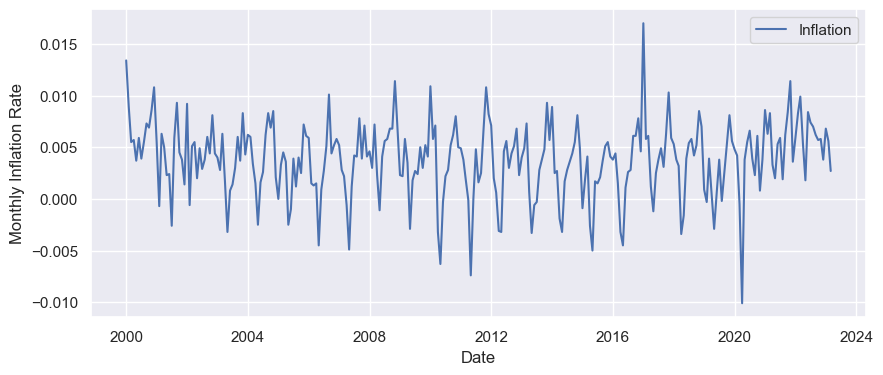

In [7]:
figure = plt.figure(figsize = (10,4))
sns.lineplot(data = inflation)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Monthly Inflation Rate')
plt.show()

## Decompose The Series

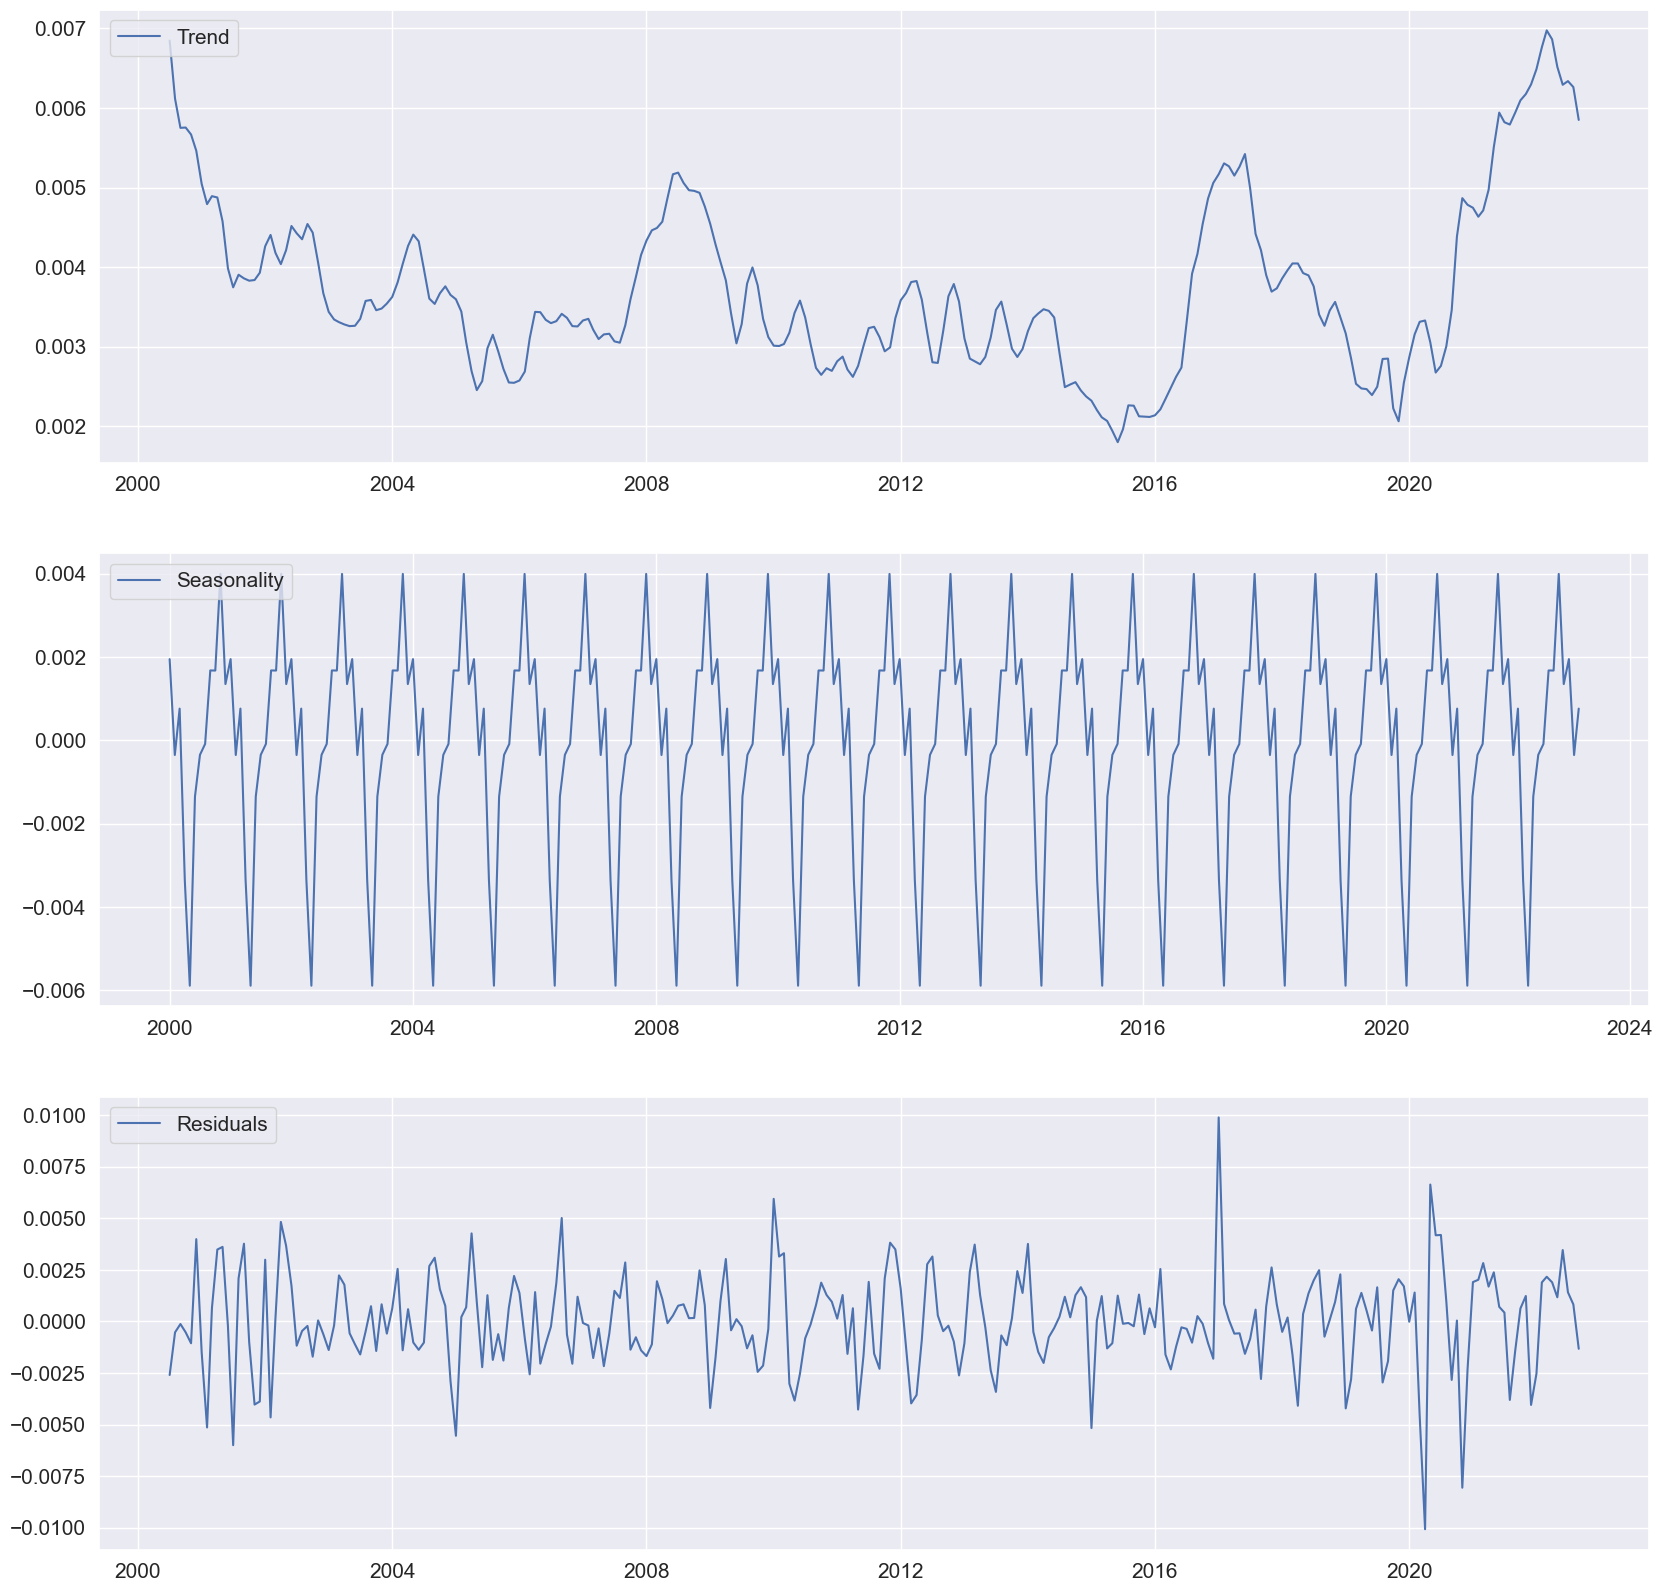

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# frequency is the time a time serie is taking to complete on cycal
ts_dicomposition = seasonal_decompose(x= inflation, model='additive', period= 12)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid

# Plotting the time series and it's components together
fig, axes = plt.subplots(3, 1, sharex=False, sharey=False)
fig.set_figheight(20)
fig.set_figwidth(20)

# second plot to be for trend
axes[0].plot(trend_estimate, label='Trend')
axes[0].legend(loc='upper left', fontsize=15)
axes[0].tick_params(axis='both', which='major', labelsize=15)
# third plot to be Seasonality component
axes[1].plot(seasonal_estimate, label='Seasonality')
axes[1].legend(loc='upper left', fontsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
# last last plot to be Residual component
axes[2].plot(residual_estimate, label='Residuals')
axes[2].legend(loc='upper left', fontsize=15)
axes[2].tick_params(axis='both', which='major', labelsize=15)

## Identify Trend

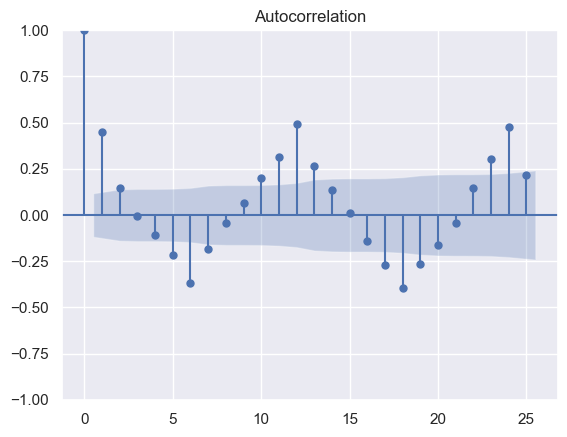

In [20]:
from statsmodels.graphics import tsaplots
fig = plt.Figure(figsize=(10,8))
tsaplots.plot_acf(inflation)
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller
#from numpy import log
result = adfuller(inflation)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.446553
p-value: 0.009471


Augmented Dickey-Fuller test

H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.

HA: The time series is stationary.

If the p-value from the test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

## Differenciate the series 

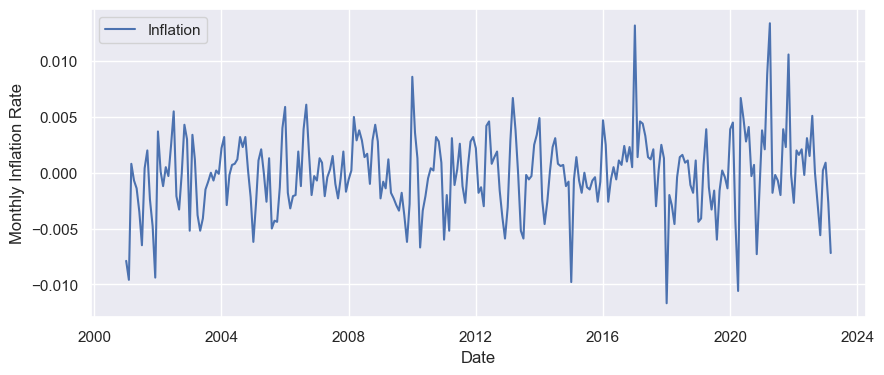

In [18]:
dif_12 = inflation.diff(12).dropna()
figure = plt.figure(figsize = (10,4))
sns.lineplot(data = dif_12)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Monthly Inflation Rate')
plt.show()

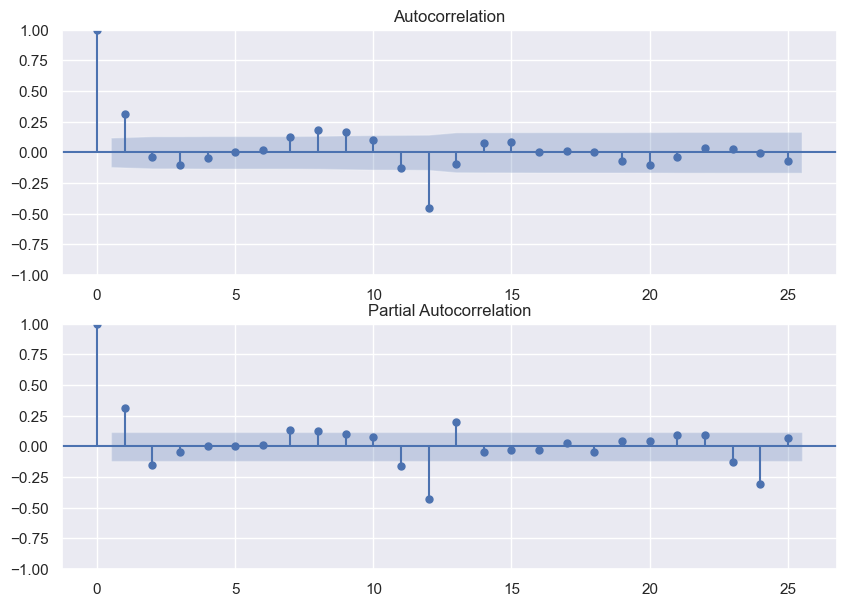

In [19]:
from statsmodels.graphics import tsaplots
fig, axes = plt.subplots(2,1,figsize=(10,7))                     
tsaplots.plot_acf(dif_12, ax = axes[0])
pacf_diff = tsaplots.plot_pacf(dif_12, ax = axes[1])
plt.show()

## Split Data

In [22]:
# Separación datos train-test
# ==============================================================================
steps = 55
data_train = inflation[:-steps]
data_test  = inflation[-steps:]

print(f"Data train : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Data test  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Data train : 2000-01-01 00:00:00 --- 2018-08-01 00:00:00  (n=224)
Data test  : 2018-09-01 00:00:00 --- 2023-03-01 00:00:00  (n=55)


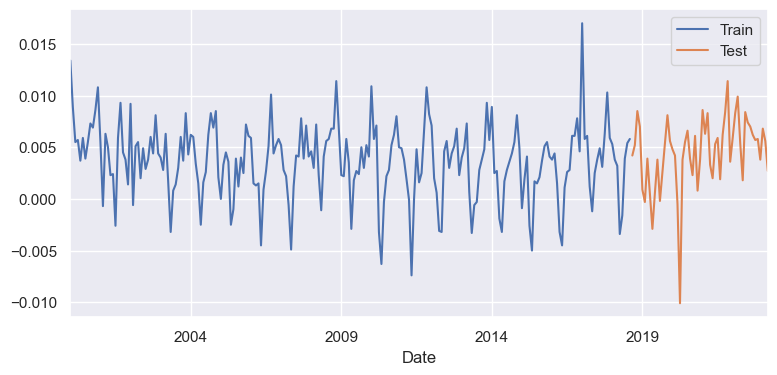

In [24]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train.plot(ax=ax)
data_test.plot(ax=ax)
ax.legend(['Train','Test'])
plt.show()

## Model

In [146]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data_train, order=(0,0,0), seasonal_order=(0,1,1,12))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                Inflation   No. Observations:                  224
Model:             ARIMA(0, 1, [1], 12)   Log Likelihood                 960.769
Date:                  Fri, 07 Apr 2023   AIC                          -1917.538
Time:                          16:16:08   BIC                          -1910.825
Sample:                      01-01-2000   HQIC                         -1914.825
                           - 08-01-2018                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.7756      0.059    -13.122      0.000      -0.892      -0.660
sigma2      6.411e-06   4.78e-07     13.415      0.000    5.47e-06    7.35e-06
===================================================================================
Ljung-Box (L1) (Q):                  25.63   Jarque-Bera (JB):                92.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.31
Prob(H) (two-sided):                  0.19   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
forecast_test = model_fit.forecast(len(data_test))
forecast = list(forecast_test)

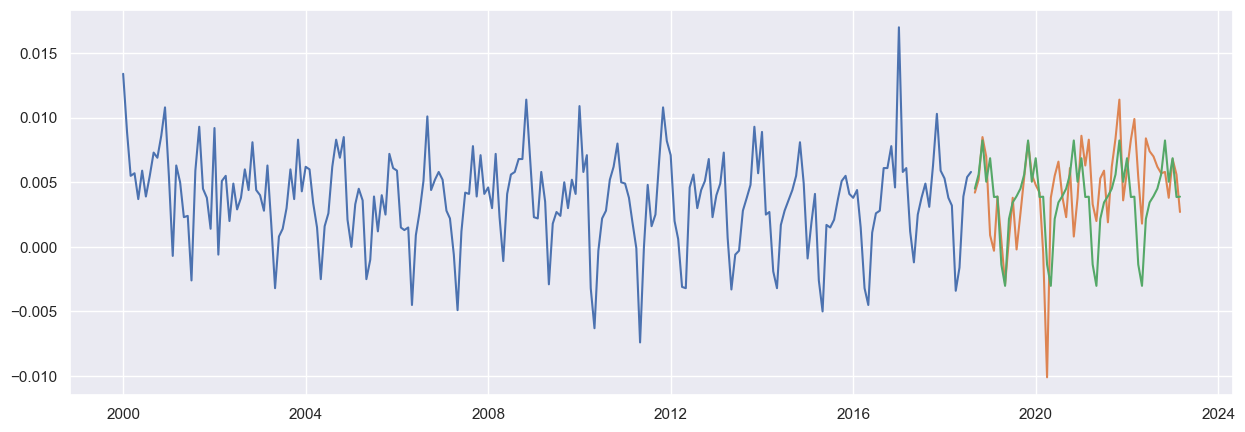

In [148]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data_train)
ax.plot(data_test)
ax.plot(forecast_test)
plt.show()

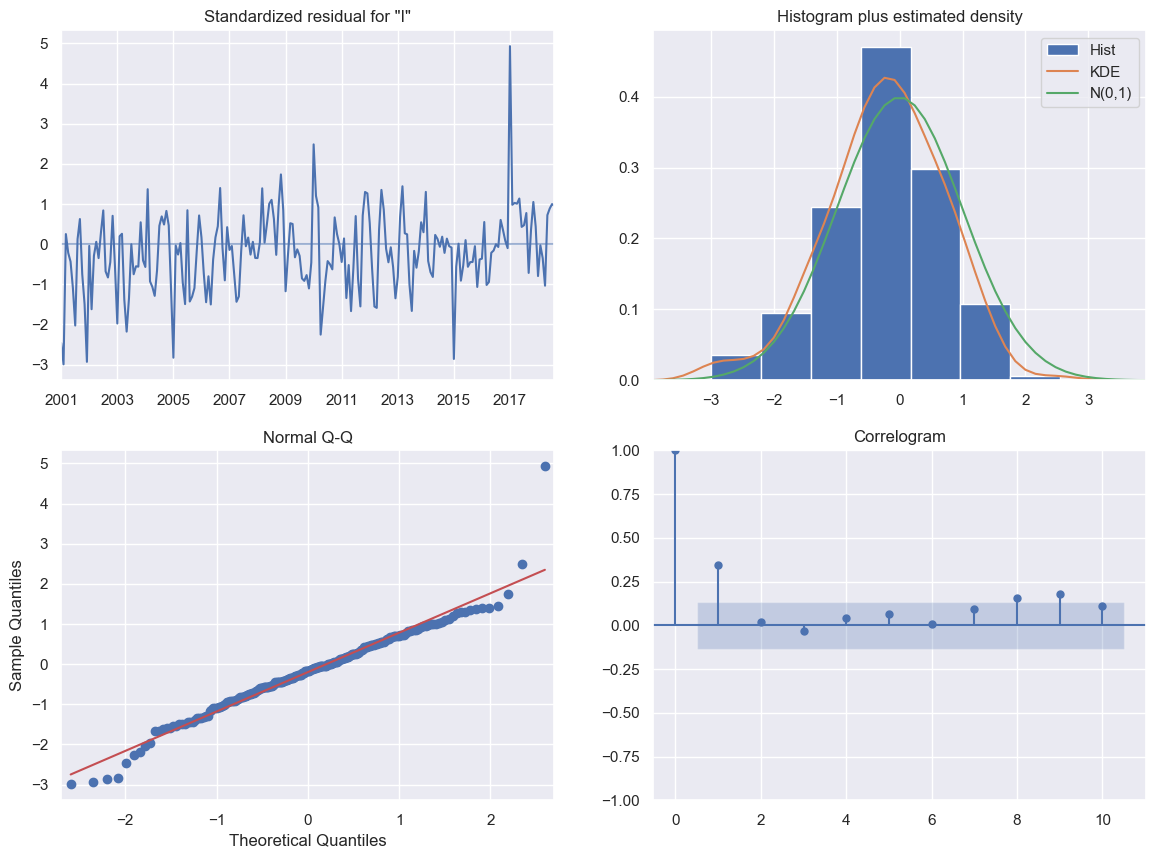

In [149]:
model_fit.plot_diagnostics(figsize=(14,10))
plt.show()

In [151]:
mae = round(mean_absolute_error(data_test, forecast),4)
mape = round(mean_absolute_percentage_error(data_test, forecast),4)
rmse = round(np.sqrt(mean_squared_error(data_test, forecast)),4)

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 0.0026
mape: 1.6324
rmse: 0.0034


## AutoARIMA

In [156]:
from pmdarima.arima import auto_arima
model = auto_arima(data_train,seasonal=True, trace= True, m=12,)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-2014.921, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1885.895, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1982.889, Time=0.17 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1967.471, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1726.166, Time=0.03 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-1970.940, Time=0.53 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-1993.931, Time=0.54 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=-2008.518, Time=0.93 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=1.57 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-1934.024, Time=0.42 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=-1984.954, Time=0.75 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=-1982.992, Time=0.54 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=-1991.665, Time=1.75 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-2043.278, Time=0.59 sec
 ARIMA(1,0,

In [157]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  224
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                1031.653
Date:                            Fri, 07 Apr 2023   AIC                          -2053.306
Time:                                    16:21:15   BIC                          -2036.248
Sample:                                01-01-2000   HQIC                         -2046.421
                                     - 08-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      1.083      0.279      -0.000       0.000
ma.L1          0.4050      0.058      7.028      0.000       0.292       0.518
ar.S.L12       0.9598      0.032     29.750      0.000       0.897       1.023
ma.S.L12      -0.7193      0.095     -7.545      0.000      -0.906      -0.532
sigma2      5.541e-06   4.19e-07     13.238      0.000    4.72e-06    6.36e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               166.08
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.55
Prob(H) (two-sided):                  0.38   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
pred, confint = model.predict(n_periods= steps, return_conf_int= True)
cf = pd.DataFrame(confint)

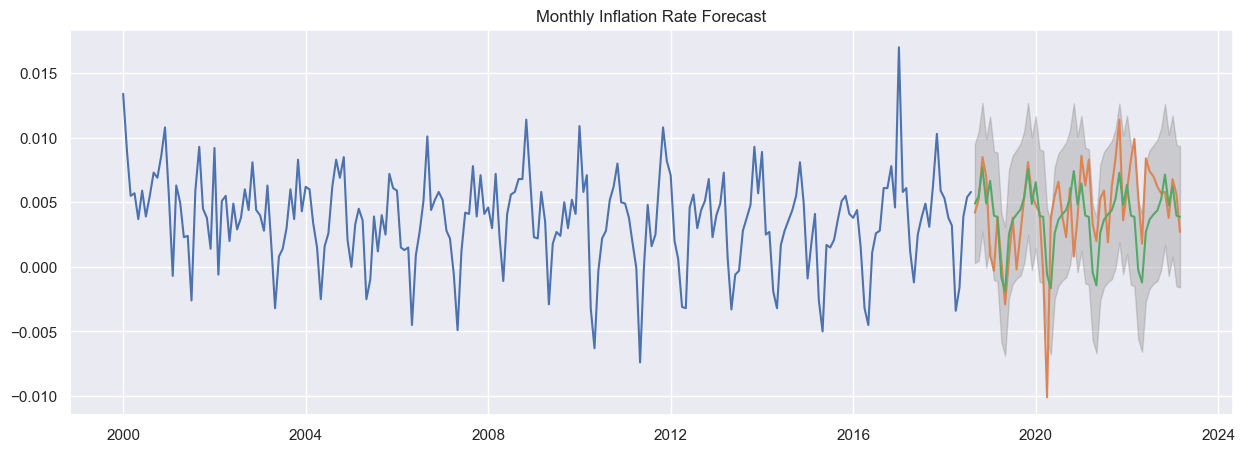

In [162]:
prediction_series = pd.Series(pred,index=data_test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data_train)
ax.plot(data_test)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
plt.title('Monthly Inflation Rate Forecast')
plt.show()

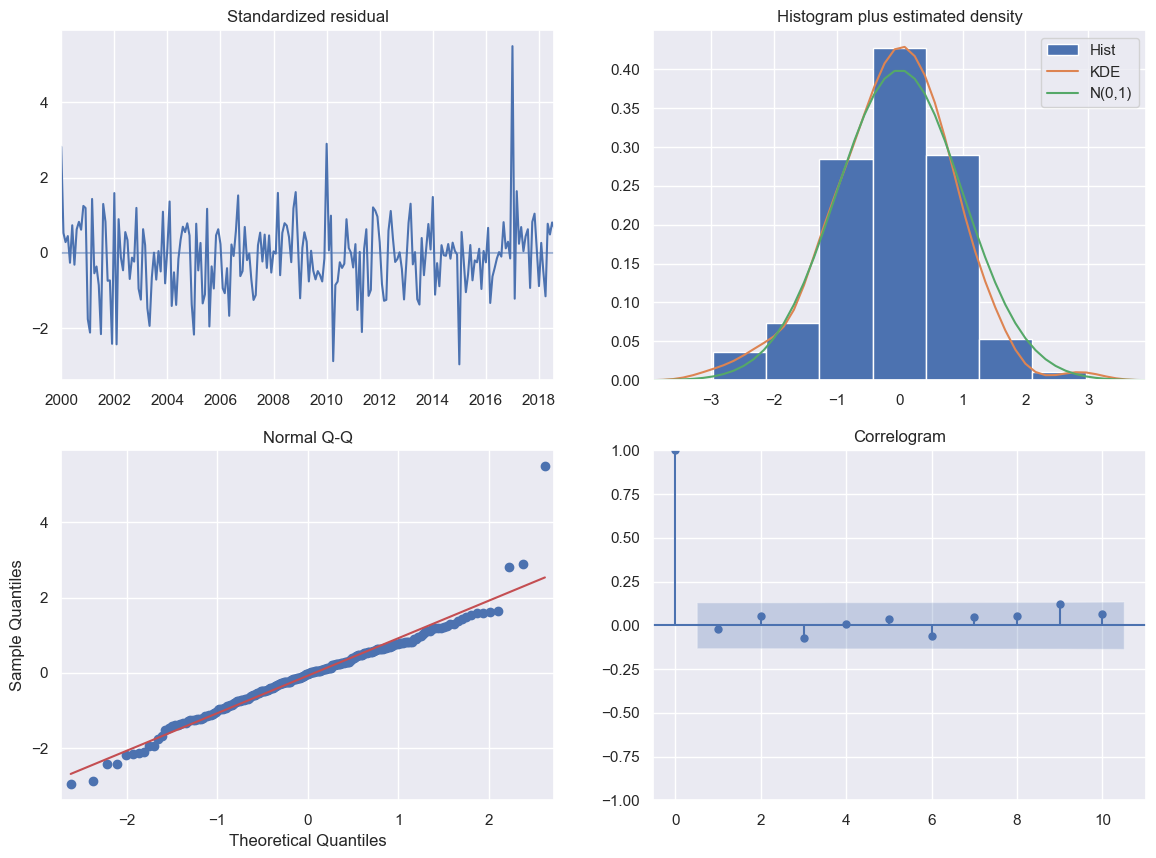

In [160]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [161]:
mae = round(mean_absolute_error(data_test, pred),4)
mape = round(mean_absolute_percentage_error(data_test, pred),4)
rmse = round(np.sqrt(mean_squared_error(data_test, pred)),4)

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

mae: 0.0025
mape: 1.5722
rmse: 0.0032
